In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from xgboost import XGBRegressor


In [ ]:
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
housing_mini = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv')

In [ ]:
housing.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,1565930130,20141104T000000,4,3.25,3760,4675,2.0,0,0,3,...,2740,1020,2007,0,98038,47.3862,-122.048,3280,4033,429900.0
1,3279000420,20150115T000000,3,1.75,1460,7800,1.0,0,0,2,...,1040,420,1979,0,98023,47.3035,-122.382,1310,7865,233000.0
2,194000575,20141014T000000,4,1.00,1340,5800,1.5,0,2,3,...,1340,0,1914,0,98116,47.5658,-122.389,1900,5800,455000.0
3,2115510160,20141208T000000,3,1.75,1440,8050,1.0,0,0,3,...,1440,0,1985,0,98023,47.3187,-122.390,1790,7488,258950.0
4,7522500005,20140815T000000,2,1.50,1780,4750,1.0,0,0,4,...,1080,700,1947,0,98117,47.6859,-122.395,1690,5962,555000.0


In [ ]:
# Current Date format: 20141104T000000

def date_format(df):
    current_year = 2024
    df["yr_from_built"] = current_year - df["yr_built"]

    df["date_time"] = pd.to_datetime(df["date"])

    df["sale_year"] = df["date_time"].dt.year
    df["sale_month"] = df["date_time"].dt.month

    df.drop("date_time", axis=1, inplace=True)
    return df

housing = date_format(housing)
housing_mini = date_format(housing_mini)

In [ ]:
!wget https://home.treasury.gov/system/files/276/yield-curve-rates-2011-2020.csv

interest_rates = pd.read_csv('yield-curve-rates-2011-2020.csv')
interest_tidy = interest_rates[['Date', '10 Yr']]
interest_tidy['yr'] = ('20' + interest_tidy['Date'].str.split('/').str[-1]).astype(int)
interest_tidy['month'] = interest_tidy['Date'].str.split('/').str[0].astype(int)
interest_tidy['day'] = interest_tidy['Date'].str.split('/').str[1].astype(int)
interest_tidy = interest_tidy.query('yr in [2014, 2015]').drop('Date', axis=1)

housing['yr'] = housing['date'].str.slice(0, 4).astype(int)
housing['month'] = housing['date'].str.slice(4, 6).astype(int)
housing['day'] = housing['date'].str.slice(6, 8).astype(int)
housing = housing.merge(interest_tidy, on=['yr', 'month', 'day'], how='left')

housing_mini['yr'] = housing_mini['date'].str.slice(0, 4).astype(int)
housing_mini['month'] = housing_mini['date'].str.slice(4, 6).astype(int)
housing_mini['day'] = housing_mini['date'].str.slice(6, 8).astype(int)
housing_mini = housing_mini.merge(interest_tidy, on=['yr', 'month', 'day'], how='left')

housing.drop("date", axis=1, inplace=True)
housing_mini.drop("date", axis=1, inplace=True)


--2024-10-26 01:24:01--  https://home.treasury.gov/system/files/276/yield-curve-rates-2011-2020.csv
Resolving home.treasury.gov (home.treasury.gov)... 23.48.104.69, 23.48.104.79, 2600:1408:c400:d::17cd:6a5a, ...
Connecting to home.treasury.gov (home.treasury.gov)|23.48.104.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘yield-curve-rates-2011-2020.csv’

yield-curve-rates-2     [ <=>                ] 159.88K  --.-KB/s    in 0.06s   

2024-10-26 01:24:04 (2.48 MB/s) - ‘yield-curve-rates-2011-2020.csv’ saved [163719]



<ipython-input-8-0174c13d26d4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interest_tidy['yr'] = ('20' + interest_tidy['Date'].str.split('/').str[-1]).astype(int)
<ipython-input-8-0174c13d26d4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interest_tidy['month'] = interest_tidy['Date'].str.split('/').str[0].astype(int)
<ipython-input-8-0174c13d26d4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [ ]:
def identify_outliers(df):
  numerical_cols = df.select_dtypes(include=np.number).columns
  outlier_table = pd.DataFrame(columns=['Column', 'Mean', 'Max', 'Min'])

  for col in numerical_cols:
    mean_val = df[col].mean()
    max_val = df[col].max()
    min_val = df[col].min()

    outlier_table = pd.concat([outlier_table, pd.DataFrame({'Column': [col], 'Mean': [mean_val], 'Max': [max_val], 'Min': [min_val]})], ignore_index=True)

  return outlier_table


outlier_stats = identify_outliers(housing)
print(outlier_stats)

# Notice houses with no bedrooms and bathrooms

           Column          Mean         Max      Min
0              id  4.580297e+09  9900000190  1000102
1        bedrooms  3.370200e+00          33        0
2       bathrooms  2.115750e+00         8.0      0.0
3     sqft_living  2.079883e+03       13540      290
4        sqft_lot  1.501533e+04     1164794      520
5          floors  1.496450e+00         3.5      1.0
6      waterfront  7.550000e-03           1        0
7            view  2.349000e-01           4        0
8       condition  3.409700e+00           5        1
9           grade  7.657700e+00          13        1
10     sqft_above  1.790233e+03        9410      290
11  sqft_basement  2.896502e+02        4820        0
12       yr_built  1.971100e+03        2015     1900
13   yr_renovated  8.273215e+01        2015        0
14        zipcode  9.807788e+04       98199    98001
15            lat  4.755997e+01     47.7776  47.1559
16           long -1.222139e+02    -121.315 -122.519
17  sqft_living15  1.986388e+03        6210   

<ipython-input-9-af834d5bc70f>:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outlier_table = pd.concat([outlier_table, pd.DataFrame({'Column': [col], 'Mean': [mean_val], 'Max': [max_val], 'Min': [min_val]})], ignore_index=True)


In [ ]:
def remove_outliers(df):
    df = df[df["bedrooms"] < 10]
    df = df[df["bedrooms"] > 0]
    df = df[df["bathrooms"] < 10]
    df = df[df["bathrooms"] > 0]
    # df = df[df["sqft_living"] < 10000]
    # df = df[df["floors"] < 10]



    return df

housing = remove_outliers(housing)

In [ ]:
housing.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_living15,sqft_lot15,price,yr_from_built,sale_year,sale_month,yr,month,day,10 Yr
0,1565930130,4,3.25,3760,4675,2.0,0,0,3,8,...,3280,4033,429900.0,17,2014,11,2014,11,4,2.35
1,3279000420,3,1.75,1460,7800,1.0,0,0,2,7,...,1310,7865,233000.0,45,2015,1,2015,1,15,1.77
2,194000575,4,1.00,1340,5800,1.5,0,2,3,7,...,1900,5800,455000.0,110,2014,10,2014,10,14,2.21
3,2115510160,3,1.75,1440,8050,1.0,0,0,3,8,...,1790,7488,258950.0,39,2014,12,2014,12,8,2.26
4,7522500005,2,1.50,1780,4750,1.0,0,0,4,7,...,1690,5962,555000.0,77,2014,8,2014,8,15,2.34


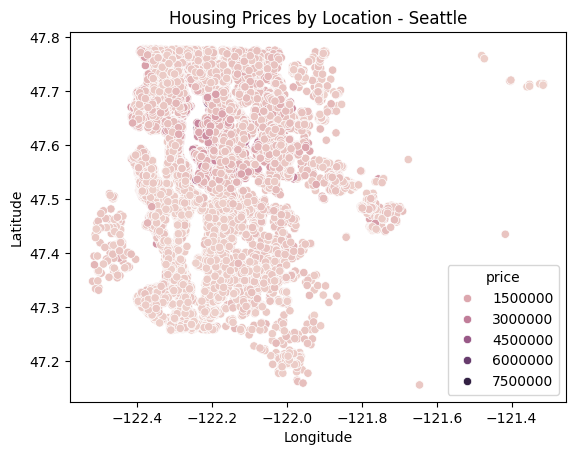

In [ ]:
sns.scatterplot(data=housing, x='long', y='lat', hue='price')
plt.title('Housing Prices by Location - Seattle')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
#import plotly.express as px

#fig = px.scatter_mapbox(housing, lat="lat", lon="long", color="price", size="price",
                        #color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
#fig.update_layout(mapbox_style="open-street-map")
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.show()

In [ ]:
from geopy.distance import geodesic


# city_center = (47.642717, -122.239780)
# 47.620564, and the longitude is -122.350616
city_center = (47.620564, -122.350616)

def calculate_distance(row):
    property_coords = (row['lat'], row['long'])
    return geodesic(property_coords, city_center).kilometers

housing['distance_to_city_center'] = housing.apply(calculate_distance, axis=1)
housing_mini['distance_to_city_center'] = housing_mini.apply(calculate_distance, axis=1)

In [ ]:
def houses_features(df):
    df['has_basement'] = df['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)
    df['is_multi_floor'] = df['floors'].apply(lambda x: 1 if x  > 1 else 0)
    return df

#housing = houses_features(housing)
#housing_mini = houses_features(housing_mini)

In [ ]:
def location_features(df):
    df['is_north_of_seattle'] = df['lat'].apply(lambda x: 1 if x > 47.604291 else 0)
    df['east_or_west_of_seattle'] = df['long'].apply(lambda x: 1 if x  > -122.3289701 else 0)
    return df

#housing = location_features(housing)
#housing_mini = location_features(housing_mini)

In [ ]:
def add_features(df):
    # df['sqft_living15'] = df['sqft_living'] * df['sqft_living15']
    # df['sqft_lot15'] = df['sqft_lot'] * df['sqft_lot15']
    # df['sqft_product'] = df['sqft_living'] * df['sqft_lot']

    df["age"] = 2024 - df["yr_built"]

    # df["has_basement"] = (df["sqft_basement"] > 0).astype(int)
    df["years_since_renovation"] = df["yr_renovated"].apply(
        lambda x: 2024 - x if x > 0 else 0
    )
    return df

#housing = add_features(housing)
#housing_mini = add_features(housing_mini)






In [ ]:
housing['Hospital'] = np.where(
    housing['zipcode'].isin([98133, 98107, 98166, 98055, 98003, 98065, 98122, 98001, 98004, 98101, 98034, 98122, 98108, 98029, 98112, 98022, 98104, 98195]), 1, 0)

housing_mini['Hospital'] = np.where(
    housing_mini['zipcode'].isin([98133, 98107, 98166, 98055, 98003, 98065, 98122, 98001, 98004, 98101, 98034, 98122, 98108, 98029, 98112, 98022, 98104, 98195]), 1, 0)

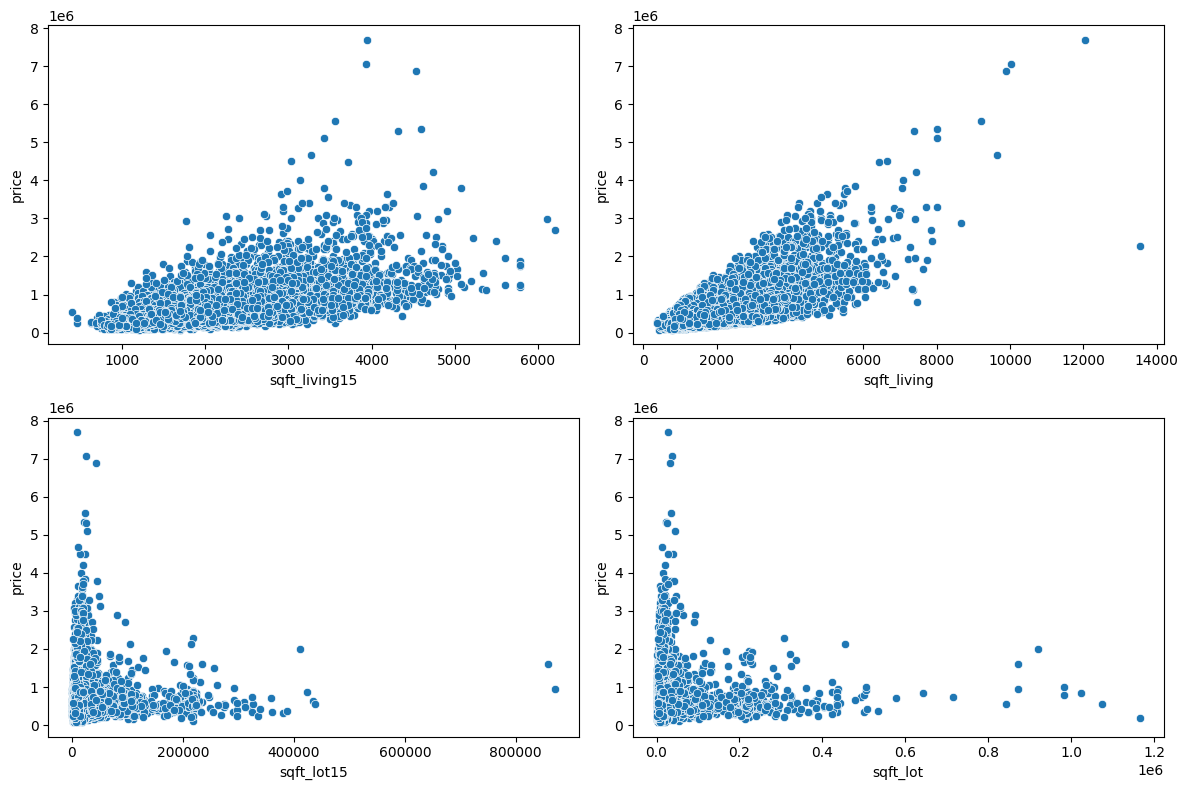

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# square footage variables
sns.scatterplot(data=housing, x='sqft_living15', y='price', ax=axes[0, 0])
sns.scatterplot(data=housing, x='sqft_living', y='price', ax=axes[0, 1])
sns.scatterplot(data=housing, x='sqft_lot15', y='price', ax=axes[1, 0])
sns.scatterplot(data=housing, x='sqft_lot', y='price', ax=axes[1, 1])

plt.tight_layout()
plt.show()

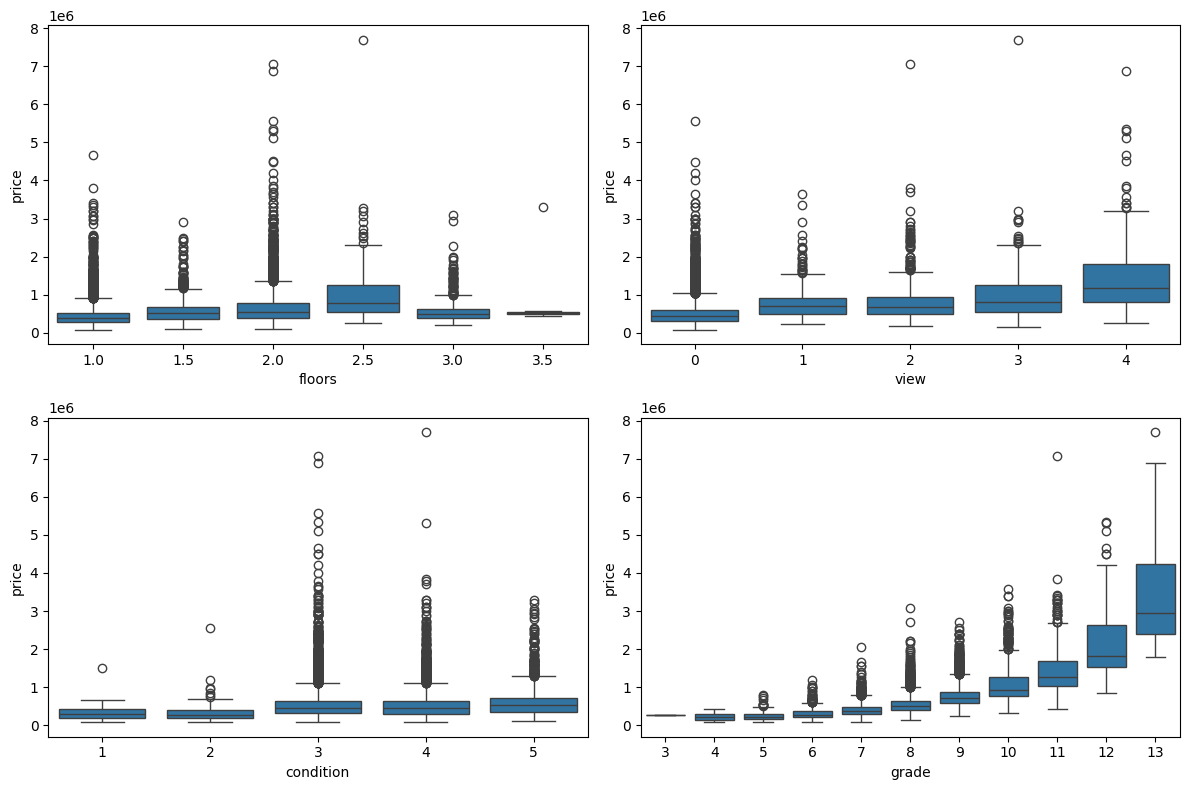

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.boxplot(data=housing, x='floors', y='price', ax=axes[0, 0])
sns.boxplot(data=housing, x='view', y='price', ax=axes[0, 1])
sns.boxplot(data=housing, x='condition', y='price', ax=axes[1, 0])
sns.boxplot(data=housing, x='grade', y='price', ax=axes[1, 1])

plt.tight_layout()
plt.show()

In [ ]:
''' fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.scatterplot(data=housing, x='yr_renovated', y='price', ax=axes[0, 0])
sns.scatterplot(data=housing, x='yr_from_built', y='price', ax=axes[0, 1])
sns.boxplot(data=housing, x='floors', y='price', ax=axes[1, 0])
sns.boxplot(data=housing, x='bedrooms', y='price', ax=axes[1, 1])

plt.tight_layout()
plt.show() '''

" fig, axes = plt.subplots(2, 2, figsize=(12, 8))\n\nsns.scatterplot(data=housing, x='yr_renovated', y='price', ax=axes[0, 0])\nsns.scatterplot(data=housing, x='yr_from_built', y='price', ax=axes[0, 1])\nsns.boxplot(data=housing, x='floors', y='price', ax=axes[1, 0])\nsns.boxplot(data=housing, x='bedrooms', y='price', ax=axes[1, 1])\n\nplt.tight_layout()\nplt.show() "

In [ ]:
''' fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.scatterplot(data=housing, x='distance_to_city_center', y='price', ax=axes[0, 0])
sns.boxplot(data=housing, x='bathrooms', y='price', ax=axes[0, 1])
sns.scatterplot(data=housing, x='sqft_above', y='price', ax=axes[1, 0])
sns.scatterplot(data=housing, x='sqft_basement', y='price', ax=axes[1, 1])

plt.tight_layout()
plt.show() '''

" fig, axes = plt.subplots(2, 2, figsize=(12, 8))\n\nsns.scatterplot(data=housing, x='distance_to_city_center', y='price', ax=axes[0, 0])\nsns.boxplot(data=housing, x='bathrooms', y='price', ax=axes[0, 1])\nsns.scatterplot(data=housing, x='sqft_above', y='price', ax=axes[1, 0])\nsns.scatterplot(data=housing, x='sqft_basement', y='price', ax=axes[1, 1])\n\nplt.tight_layout()\nplt.show() "

In [ ]:
#fig, axes = plt.subplots(2, 2, figsize=(12, 8))

#sns.scatterplot(data=housing, x='yr_from_built', y='price', ax=axes[0, 0])
#sns.histplot(data=housing, x='sale_year', ax=axes[0, 1])
#sns.scatterplot(data=housing, x='yr_built', y='price', ax=axes[1, 0])
#sns.scatterplot(data=housing, x='sqft_basement', y='price', ax=axes[1, 1])

# Examples of other charts
# sns.boxplot(data=housing, x='bedrooms', y='price', ax=axes[0, 1])
# sns.histplot(data=housing, x='grade', ax=axes[1, 0])
# sns.heatmap(housing.corr(), annot=True, ax=axes[1, 1])

#plt.tight_layout()
#plt.show()

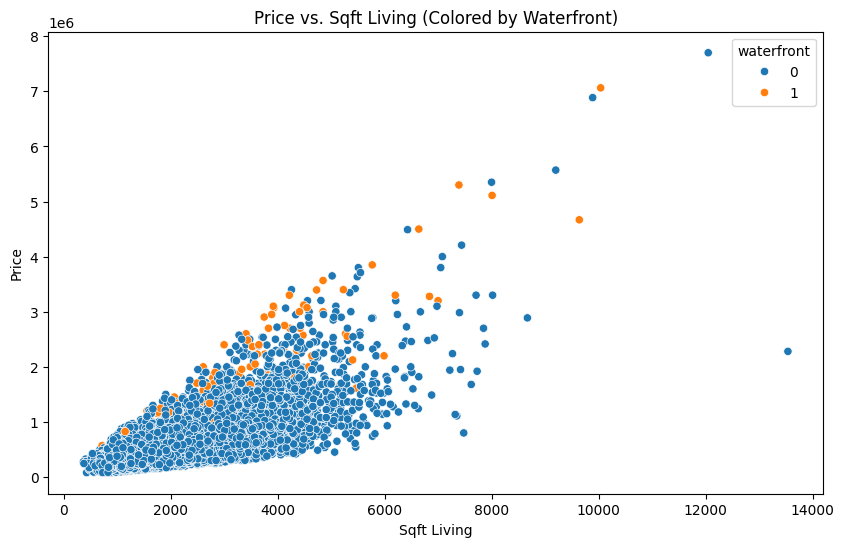

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sqft_living', y='price', hue='waterfront', data=housing)
plt.title('Price vs. Sqft Living (Colored by Waterfront)')
plt.xlabel('Sqft Living')
plt.ylabel('Price')
plt.show()

In [ ]:
''' from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
housing['zipcode'] = le.fit_transform(housing['zipcode'])
housing_mini['zipcode'] = le.transform(housing_mini['zipcode']) '''

" from sklearn.preprocessing import LabelEncoder\n\nle = LabelEncoder()\nhousing['zipcode'] = le.fit_transform(housing['zipcode'])\nhousing_mini['zipcode'] = le.transform(housing_mini['zipcode']) "

In [ ]:
# housing.head()

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19981 entries, 0 to 19999
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       19981 non-null  int64  
 1   bedrooms                 19981 non-null  int64  
 2   bathrooms                19981 non-null  float64
 3   sqft_living              19981 non-null  int64  
 4   sqft_lot                 19981 non-null  int64  
 5   floors                   19981 non-null  float64
 6   waterfront               19981 non-null  int64  
 7   view                     19981 non-null  int64  
 8   condition                19981 non-null  int64  
 9   grade                    19981 non-null  int64  
 10  sqft_above               19981 non-null  int64  
 11  sqft_basement            19981 non-null  int64  
 12  yr_built                 19981 non-null  int64  
 13  yr_renovated             19981 non-null  int64  
 14  zipcode                  19

In [ ]:
def combine_quality(df):
  df['quality_combined'] = (df['waterfront'] / df['waterfront'].max()) + (df['view'] / df['view'].max()) + (df['condition'] / df['condition'].max()) + (df['grade'] / df['grade'].max())
  return df

housing = combine_quality(housing)
housing_mini = combine_quality(housing_mini)

In [ ]:
# based on the charts we can decide what variable we need to drop. This is only an example, we need to analize more variables
def clean_data(df):
    df.drop("id", axis=1, inplace=True)
    df.drop("sqft_basement", axis=1, inplace=True)
    #df.drop("yr_from_built", axis=1, inplace=True)
    df.drop("sale_year", axis=1, inplace=True)
    df.drop("sale_month", axis=1, inplace=True)
    df.drop("floors", axis=1, inplace=True)
    df.drop("sqft_lot", axis=1, inplace=True)
    df.drop("sqft_lot15", axis=1, inplace=True)
    #df.drop("yr_renovated", axis=1, inplace=True)
    df.drop("yr_built", axis=1, inplace=True)
    #df.drop("age", axis=1, inplace=True)
    #df.drop("years_since_renovation", axis=1, inplace=True)
    # df.drop("sqft_living", axis=1, inplace=True)
    #df.drop("sqft_living15", axis=1, inplace=True)
    # df.drop("lat", axis=1, inplace=True)
    # df.drop("long", axis=1, inplace=True)
    df.drop("zipcode", axis=1, inplace=True)
    #df.drop("bedrooms", axis=1, inplace=True)
    # df.drop("zipcode", axis=1, inplace=True)
    df.drop("sqft_above",axis=1,inplace=True)
    df.drop("waterfront",axis=1,inplace=True)
    #df.drop("grade",axis=1,inplace=True)
    df.drop("view", axis=1, inplace=True)
    df.drop("condition", axis=1, inplace=True)
    df.drop("yr", axis=1, inplace=True)
    df.drop("month", axis=1, inplace=True)
    df.drop("day", axis=1, inplace=True)
    df.drop("Hospital", axis=1, inplace=True)
    df.drop("yr_renovated", axis=1, inplace=True)
    df.drop("10 Yr", axis=1, inplace=True)

    return df

housing = clean_data(housing)
housing_mini = clean_data(housing_mini)

In [ ]:
housing.head()

,bedrooms,bathrooms,sqft_living,grade,lat,long,sqft_living15,price,yr_from_built,distance_to_city_center,quality_combined
0,4,3.25,3760,8,47.3862,-122.048,3280,429900.0,17,34.622692,1.215385
1,3,1.75,1460,7,47.3035,-122.382,1310,233000.0,45,35.330458,0.938462
2,4,1.00,1340,7,47.5658,-122.389,1900,455000.0,110,6.738501,1.638462
3,3,1.75,1440,8,47.3187,-122.390,1790,258950.0,39,33.692311,1.215385
4,2,1.50,1780,7,47.6859,-122.395,1690,555000.0,77,7.992966,1.338462


In [ ]:

X = housing.drop("price", axis=1)

y = housing["price"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=10
)

model = XGBRegressor(objective="reg:squarederror")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

RMSE: 111360.48052424718
R-squared: 0.8972017953593528


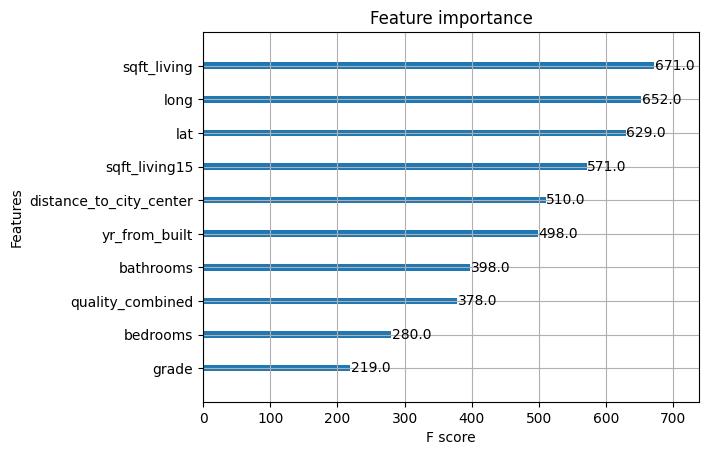

In [ ]:
from xgboost import plot_importance

plot_importance(model)
plt.show()

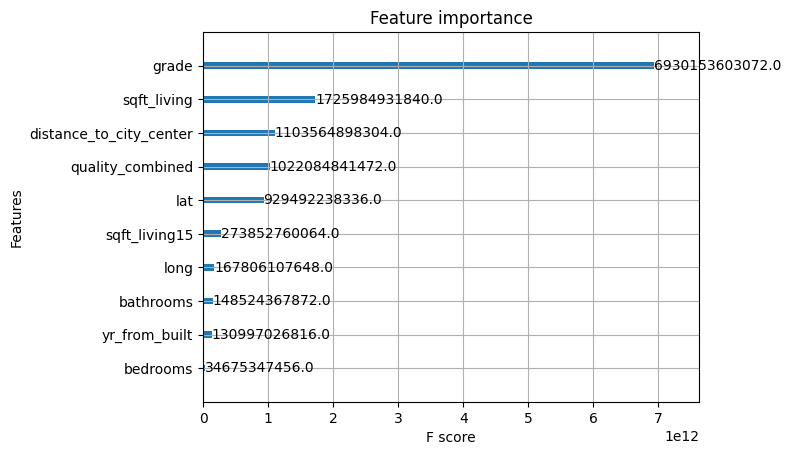

In [ ]:
plot_importance(model, importance_type='gain')
plt.show()

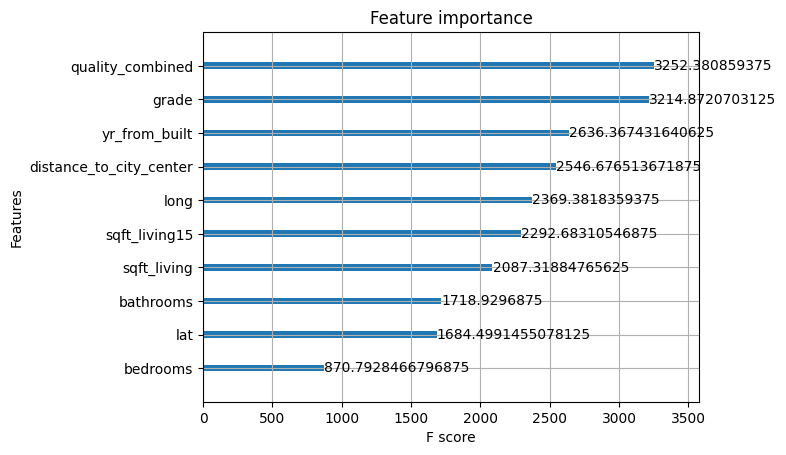

In [ ]:
plot_importance(model, importance_type='cover')
plt.show()

In [ ]:
housing_mini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bedrooms                 81 non-null     int64  
 1   bathrooms                81 non-null     float64
 2   sqft_living              81 non-null     int64  
 3   grade                    81 non-null     int64  
 4   lat                      81 non-null     float64
 5   long                     81 non-null     float64
 6   sqft_living15            81 non-null     int64  
 7   yr_from_built            81 non-null     int64  
 8   distance_to_city_center  81 non-null     float64
 9   quality_combined         81 non-null     float64
dtypes: float64(5), int64(5)
memory usage: 6.5 KB


In [ ]:
# Holdout dataset mini
x_holdout = housing_mini
predictions = model.predict(x_holdout)

predictions_df = pd.DataFrame(predictions, columns=['predictions'])
predictions_df.to_csv('team9-module3-predictions.csv', index=False)

In [ ]:
''' from google.colab import files
files.download('team9-module3-predictions.csv') '''

" from google.colab import files\nfiles.download('team9-module3-predictions.csv') "

In [ ]:
# isaac stuff.
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
housing_mini = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv')
housing_holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test.csv')

def date_format(df):
    current_year = 2024
    df["yr_from_built"] = current_year - df["yr_built"]

    df["date"] = pd.to_datetime(df["date"])

    df["sale_year"] = df["date"].dt.year
    df["sale_month"] = df["date"].dt.month

    df.drop("date", axis=1, inplace=True)
    return df

housing = date_format(housing)
housing_mini = date_format(housing_mini)
housing_holdout = date_format(housing_holdout)
def remove_outliers(df):
    df = df[df["bedrooms"] < 10]
    df = df[df["bedrooms"] > 0]
    df = df[df["bathrooms"] < 10]
    df = df[df["bathrooms"] > 0]
    # df = df[df["sqft_living"] < 10000]
    # df = df[df["floors"] < 10]


    return df

housing = remove_outliers(housing)

from geopy.distance import geodesic


city_center = (47.642717, -122.239780)

def calculate_distance(row):
    property_coords = (row['lat'], row['long'])
    return geodesic(property_coords, city_center).kilometers

housing['distance_to_city_center'] = housing.apply(calculate_distance, axis=1)
housing_mini['distance_to_city_center'] = housing_mini.apply(calculate_distance, axis=1)
housing_holdout['distance_to_city_center'] = housing_holdout.apply(calculate_distance, axis=1)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
housing['zipcode'] = le.fit_transform(housing['zipcode'])
housing_mini['zipcode'] = le.transform(housing_mini['zipcode'])
housing_holdout['zipcode'] = le.transform(housing_holdout['zipcode'])
def clean_data(df):
    df.drop("id", axis=1, inplace=True)
    df.drop("sqft_basement", axis=1, inplace=True)
    #df.drop("yr_from_built", axis=1, inplace=True)
    df.drop("sale_year", axis=1, inplace=True)
    #df.drop("sale_month", axis=1, inplace=True)
    df.drop("floors", axis=1, inplace=True)
    df.drop("sqft_lot", axis=1, inplace=True)
    df.drop("sqft_lot15", axis=1, inplace=True)
    df.drop("yr_renovated", axis=1, inplace=True)
    df.drop("yr_built", axis=1, inplace=True)
    #df.drop("age", axis=1, inplace=True)
    #df.drop("years_since_renovation", axis=1, inplace=True)
    # df.drop("sqft_living", axis=1, inplace=True)
    # df.drop("sqft_living15", axis=1, inplace=True)
    # df.drop("lat", axis=1, inplace=True)
    # df.drop("long", axis=1, inplace=True)
    df.drop("zipcode", axis=1, inplace=True)
    #df.drop("bedrooms", axis=1, inplace=True)
    # df.drop("zipcode", axis=1, inplace=True)
    df.drop("sqft_above",axis=1,inplace=True)
    #df.drop("waterfront",axis=1,inplace=True)
    #df.drop("grade",axis=1,inplace=True)
    #df.drop("view", axis=1, inplace=True)
    #df.drop("condition", axis=1, inplace=True)

    return df

housing = clean_data(housing)
housing_mini = clean_data(housing_mini)
housing_holdout = clean_data(housing_holdout)
X = housing.drop("price", axis=1)

y = housing["price"]

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.1, random_state=10
#)

model = XGBRegressor(objective="reg:squarederror", alpha=600000)

model.fit(X, y)
#y_pred = model.predict(X_test)

#Evaluate the model
#rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#r2 = r2_score(y_test, y_pred)

#print(f"RMSE: {rmse}")
#print(f"R-squared: {r2}")

#if you get something better, throw all your code to make it down here in a new code box so we can save it.
x_holdout = housing_holdout
predictions = model.predict(x_holdout)

predictions_df = pd.DataFrame(predictions, columns=['predictions'])
predictions_df.to_csv('team9-module3-predictions.csv', index=False)

from google.colab import files
files.download('team9-module3-predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

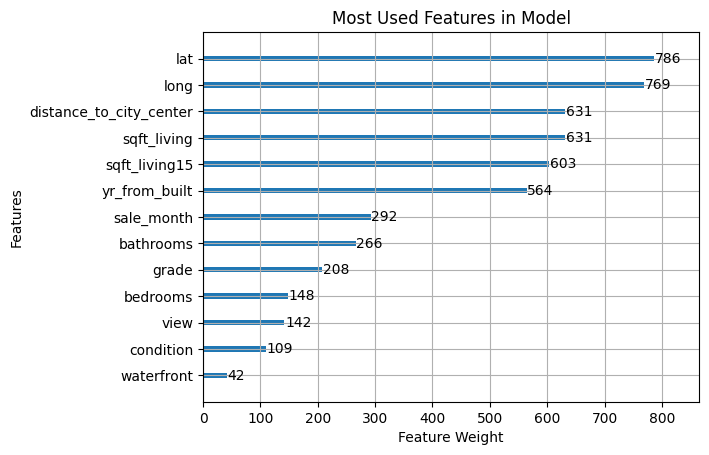

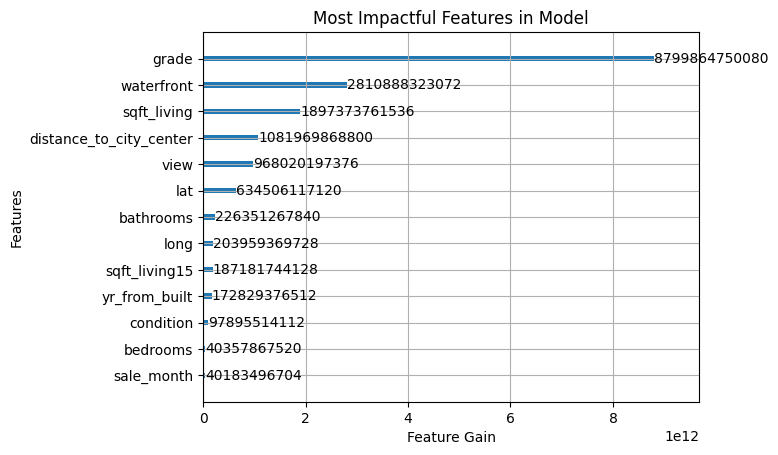

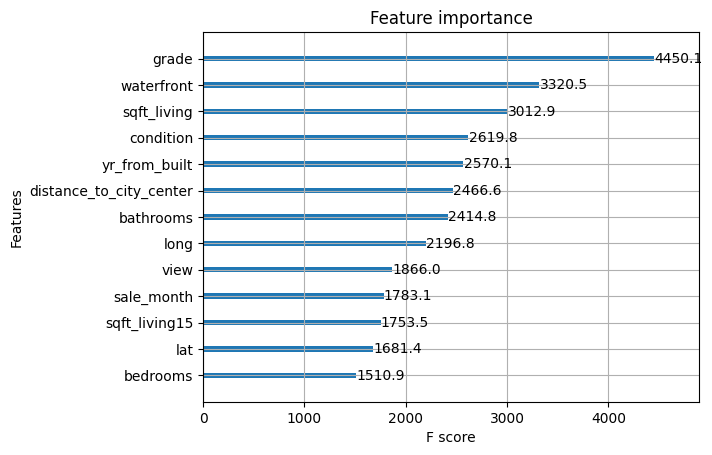

In [ ]:
plot_importance(model, values_format ='{v:.0f}', title='Most Used Features in Model', xlabel='Feature Weight')
plt.show()
plot_importance(model, importance_type='gain', title='Most Impactful Features in Model', xlabel='Feature Gain', values_format ='{v:.0f}')
plt.show()
plot_importance(model, importance_type='cover',values_format ='{v:.1f}')
plt.show()